## VIX Future Returns, post 2013

In [3]:
import requests
import pandas as pd
import io
import re
import matplotlib.pyplot as plt
import numpy as np

Load fetched VIX Futures data:

In [4]:
VIX_FUT = pd.read_csv('DATA/VIX_FUT_post2013.csv',usecols = ['DATE','EXPIRY_DATE','CLOSE','DAYS','SETTLE'])
VIX_FUT['DATE'] = pd.to_datetime(VIX_FUT['DATE'])

#Drop values with 0 settle price
IND_DROP = VIX_FUT[VIX_FUT.SETTLE == 0].index
VIX_FUT = VIX_FUT.drop(IND_DROP)

#Sort
VIX_FUT = VIX_FUT.sort_values(by=['DATE','DAYS'])

#All dates in data
DATES = VIX_FUT.DATE.unique()

#maturities of interest
MAT = [30,60,91,122,152,182]

Data from author:

In [5]:
VIX_FUT_RET = pd.read_csv('DATA/VIX_FUT_RET.csv',skiprows=5)


orig_names = VIX_FUT_RET.columns

VIX_FUT_RET = VIX_FUT_RET.rename({'Date':'DATE','r_1^{VIX fut.}':'1 month','r_2^{VIX fut.}':'2 month','r_3^{VIX fut.}':'3 month',
                         'r_4^{VIX fut.}':'4 month','r_5^{VIX fut.}':'5 month','r_6^{VIX fut.}':'6 month'},axis=1)

def DATE_STR(num):
    num_str = str(num)
    date_str = num_str[-2:]+'/'+num_str[4:-2]+'/'+num_str[0:4]
    
    return date_str 

VIX_FUT_RET['DATE'] = VIX_FUT_RET['DATE'].apply(DATE_STR)
VIX_FUT_RET['DATE'] = pd.to_datetime(VIX_FUT_RET['DATE'],format = '%d/%m/%Y')

Function used to get the closest maturities to the term of interest, we then linearly inter/extra-polate from these values.

In [6]:
def CLOSEST_IND(LIST,VAL): #list is sorted
    DIFF = np.array(LIST) - VAL
    
    enum_DIFF = [(i,abs(e)) for i,e in enumerate(DIFF)]
    enum_DIFF.sort(key=lambda a: a[1])
    (IND1,IND2) = (enum_DIFF[0][0],enum_DIFF[1][0])
    
    return (IND1,IND2) if IND1 < IND2 else (IND2, IND1)

### Method 1

Get all possible values for method 1, i.e all terms

In [11]:
VIX_FUT_RET_CUST_1 = pd.DataFrame(columns=VIX_FUT_RET.columns)
VIX_FUT_RET_CUST_1.DATE = DATES

N = len(MAT)

for n in range(0,N):
    T = MAT[n]
    df = pd.DataFrame({'DATE':DATES,'SYNTH_PRICE':None,'RETURN':None})


    for date in DATES:
        df_day = VIX_FUT[VIX_FUT['DATE'] == date]
        if len(df_day) == 1:
            next
        else:
            
            (IND1,IND2) = CLOSEST_IND(df_day.DAYS.values,T)

            S1 = df_day.DAYS.values[IND1]
            S2 = df_day.DAYS.values[IND2]

            w1 = (S2 - T)/(S2- S1)
            w2 = (T - S1)/(S2- S1)

            P1 = df_day.SETTLE.values[IND1]
            P2 = df_day.SETTLE.values[IND2]

            df.loc[df.DATE == date,'SYNTH_PRICE'] = w1*P1 + w2*P2

    df['RETURN'] = df['SYNTH_PRICE']/df['SYNTH_PRICE'].shift(1) - 1
    
    VIX_FUT_RET_CUST_1.iloc[:,n+1] = df['RETURN']*100

C:\Users\Camer\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Camer\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Camer\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


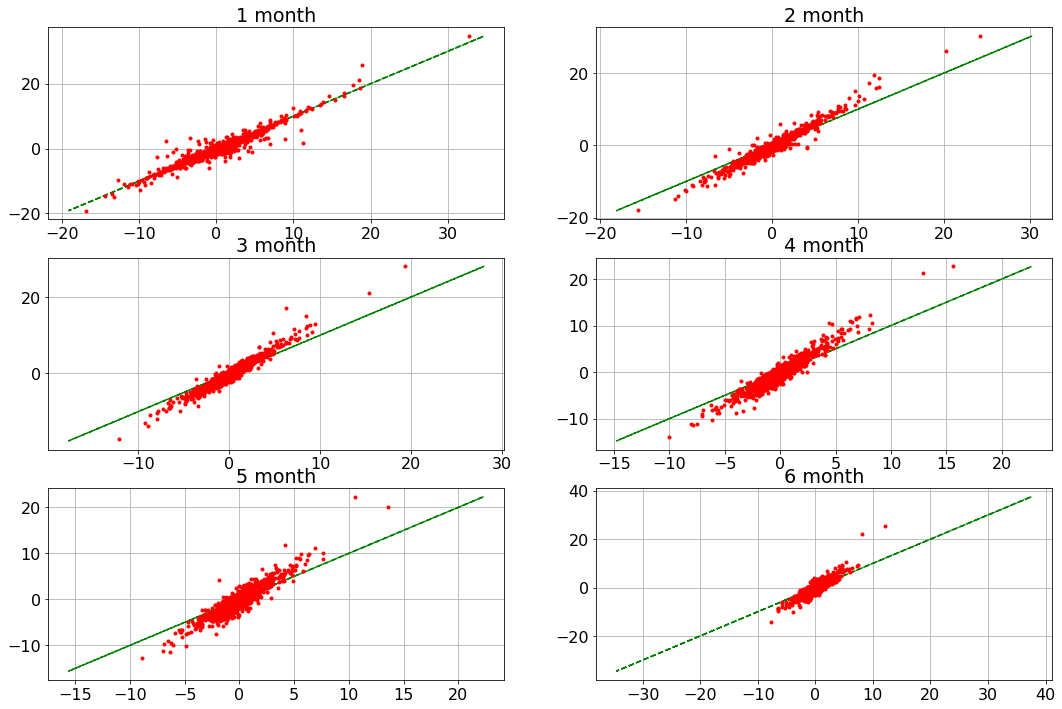

In [12]:
df_join = pd.merge(VIX_FUT_RET,VIX_FUT_RET_CUST_1,on='DATE',how='left')

plt.figure(figsize=(18,12))
plt.rcParams.update({'font.size': 16})

for n in range(0,N):
    COL = VIX_FUT_RET_CUST_1.columns[n+1]
    
    plt.subplot(3,2,n+1)
    X = df_join.iloc[:,7+n]
    Y = df_join.iloc[:,1+n]
    plt.plot(Y,Y,'--g')
    plt.plot(X,Y,'.r')
    plt.grid()
    plt.title(COL)

In [13]:
df_join.iloc[:,7:] = df_join.iloc[:,7:].apply(pd.to_numeric)
CORRS = df_join.corr().values[6:,:6]
print('Correlation Coefficients')
for n in range(0,N):
    TERM = VIX_FUT_RET_CUST_1.columns[n+1]
    print(TERM+': '+str(CORRS[n,n]))

Correlation Coefficients
1 month: 0.9644464221880593
2 month: 0.9753913440845839
3 month: 0.9700861304960022
4 month: 0.9535676920110688
5 month: 0.9239130354904861
6 month: 0.8906807403055892


In [ ]:
VIX_FUT_RET_CUST_1.columns = orig_names

PATH = './' #where to save the data

VIX_FUT_RET_CUST_1.dropna().to_csv(PATH + 'OUR_VIX_FUT_RET_post2013.csv')

### Method 2

In [10]:
VIX_FUT_RET_CUST_2 = pd.DataFrame(columns=VIX_FUT_RET.columns)
VIX_FUT_RET_CUST_2.DATE = DATES


N = len(MAT)
for n in range(0,N):
    T = MAT[n]
    
    df = pd.DataFrame({'DATE':DATES,'PORTFOLIO_t':None,'PORTFOLIO_t1':None})

    for ind in range(0,len(DATES[:-1])):
        date_t = DATES[ind]
        date_t1 = DATES[ind+1]

        #construct portfolio today

        df_day = VIX_FUT[VIX_FUT['DATE'] == date_t]
        if len(df_day) == 1:
            next
        else:

            (IND1,IND2) = CLOSEST_IND(df_day.DAYS.values,T)

            S1 = df_day.DAYS.values[IND1]
            S2 = df_day.DAYS.values[IND2]

            w1 = (S2 - T)/(S2- S1)
            w2 = (T - S1)/(S2- S1)

            F1 = df_day.EXPIRY_DATE.values[IND1]
            F2 = df_day.EXPIRY_DATE.values[IND2] 

            P1_t = df_day.SETTLE.values[IND1]
            P2_t = df_day.SETTLE.values[IND2]

            P1_t1 = VIX_FUT.loc[(VIX_FUT['DATE'] == date_t1) & (VIX_FUT['EXPIRY_DATE'] == F1),'SETTLE'].values
            P2_t1 = VIX_FUT.loc[(VIX_FUT['DATE'] == date_t1) & (VIX_FUT['EXPIRY_DATE'] == F2),'SETTLE'].values

            if len(P1_t1) == 0:
                P1_t1 = P1_t
            if len(P2_t1) == 0:
                P2_t1 = P2_t

            df.loc[df.DATE == date_t,'PORTFOLIO_t'] = w1*P1_t + w2*P2_t
            df.loc[df.DATE == date_t,'PORTFOLIO_t1'] = w1*P1_t1 + w2*P2_t1

        df['RETURN_shifted'] = df['PORTFOLIO_t1']/df['PORTFOLIO_t'] - 1
        df['RETURN'] = df['RETURN_shifted'].shift(1)
    
    VIX_FUT_RET_CUST_2.iloc[:,n+1] = df['RETURN']*100

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
df_join = pd.merge(VIX_FUT_RET,VIX_FUT_RET_CUST_2,on='DATE',how='left')

plt.figure(figsize=(18,12))
plt.rcParams.update({'font.size': 16})

for n in range(0,N):
    COL = VIX_FUT_RET_CUST_2.columns[n+1]
    
    plt.subplot(3,2,n+1)
    X = df_join.iloc[:,7+n]
    Y = df_join.iloc[:,1+n]
    plt.plot(Y,Y,'--g')
    plt.plot(X,Y,'.r')
    plt.grid()
    plt.title(COL)

In [ ]:
df_join.iloc[:,7:] = df_join.iloc[:,7:].apply(pd.to_numeric)
CORRS = df_join.corr().values[6:,:6]
print('Correlation Coefficients')
for n in range(0,N):
    TERM = VIX_FUT_RET_CUST_1.columns[n+1]
    print(TERM+': '+str(CORRS[n,n]))